In [1]:
# Sel 1: Impor Pustaka
# =============================================================================
# ### 1. Impor Pustaka 📚
# =============================================================================
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings

warnings.filterwarnings('ignore') # Sebaiknya hanya untuk development
print("✅ Pustaka berhasil diimpor.")

✅ Pustaka berhasil diimpor.


In [2]:
# =============================================================================
# ### 2. Memuat Data Log Normal untuk Training 📂
# =============================================================================
# !!! GANTI INI DENGAN PATH KE FILE DATA TRAINING NORMAL ANDA !!!
# File ini harus berisi log yang Anda anggap 100% normal.
# Formatnya diasumsikan memiliki header syslog diikuti key=value.
file_path_normal_training = 'data/syslog_normal_tgl_01.log' # Pastikan path ini benar

# Menggunakan fungsi parse_log_file dari models.py
# Pastikan models.py ada di path Python atau di direktori yang sama dengan notebook ini
try:
    # Hapus sys.path append jika models.py ada di direktori yang sama atau sudah di PYTHONPATH
    # import sys
    # # Asumsi notebook ada di root proyek, dan models.py juga di root
    # if '.' not in sys.path: # Tambahkan direktori saat ini ke path jika belum ada
    # sys.path.append('.')
    from models import parse_log_file, get_autoencoder_anomalies, get_ocsvm_anomalies
except ImportError:
    print("❌ Error: Tidak dapat mengimpor parse_log_file dari models.py.")
    print("Pastikan models.py dapat diakses (misalnya, di direktori yang sama atau di PYTHONPATH).")
    raise

print(f"Memuat data log normal untuk training dari: {file_path_normal_training}")
if not os.path.exists(file_path_normal_training):
    print(f"❌ ERROR: File training '{file_path_normal_training}' TIDAK DITEMUKAN.")
    raise FileNotFoundError(f"File training tidak ditemukan: {file_path_normal_training}")

df_logs = parse_log_file(file_path_normal_training) #

if df_logs.empty:
    print(f"❌ Error: Tidak ada data yang berhasil diparsing dari {file_path_normal_training} atau file kosong.")
    raise ValueError("DataFrame df_logs kosong setelah parsing. Training tidak dapat dilanjutkan.")
else:
    print(f"✅ Berhasil memuat dan mem-parsing {len(df_logs)} baris log normal untuk training.")
    print("\n📋 Pratinjau Data Log Normal (5 baris pertama):")
    print(df_logs.head())
    if '_raw_log_line_' in df_logs.columns:
        print("\n📋 Contoh _raw_log_line_ (menunjukkan baris log asli termasuk header syslog):")
        for line in df_logs['_raw_log_line_'].head(2).to_list():
            print(line)

Memuat data log normal untuk training dari: data/syslog_normal_tgl_01.log
✅ Berhasil memuat dan mem-parsing 439571 baris log normal untuk training.

📋 Pratinjau Data Log Normal (5 baris pertama):
         date      time                devname             devid       logid  \
0  2024-10-01  00:00:04  scientia_potentia_est  FGT80C3913601127  0001000014   
1  2024-10-01  00:00:04  scientia_potentia_est  FGT80C3913601127  0001000014   
2  2024-10-01  00:00:06  scientia_potentia_est  FGT80C3913601127  0000000011   
3  2024-10-01  00:00:06  scientia_potentia_est  FGT80C3913601127  0000000013   
4  2024-10-01  00:00:06  scientia_potentia_est  FGT80C3913601127  0000000011   

      type  subtype    level    vd          srcip  ... sentpkt rcvdpkt  \
0  traffic    local   notice  root   192.168.10.1  ...       2       2   
1  traffic    local   notice  root   192.168.10.1  ...       2       2   
2  traffic  forward  warning  root  192.168.10.52  ...     NaN     NaN   
3  traffic  forward   notic



### 3. Exploratory Data Analysis (EDA) pada Data Training Normal ###

Jumlah total log dalam data training normal: 439571

📋 Beberapa baris pertama data (df_logs.head()):
         date      time                devname             devid       logid  \
0  2024-10-01  00:00:04  scientia_potentia_est  FGT80C3913601127  0001000014   
1  2024-10-01  00:00:04  scientia_potentia_est  FGT80C3913601127  0001000014   
2  2024-10-01  00:00:06  scientia_potentia_est  FGT80C3913601127  0000000011   
3  2024-10-01  00:00:06  scientia_potentia_est  FGT80C3913601127  0000000013   
4  2024-10-01  00:00:06  scientia_potentia_est  FGT80C3913601127  0000000011   

      type  subtype    level    vd          srcip  ... sentpkt rcvdpkt  \
0  traffic    local   notice  root   192.168.10.1  ...       2       2   
1  traffic    local   notice  root   192.168.10.1  ...       2       2   
2  traffic  forward  warning  root  192.168.10.52  ...     NaN     NaN   
3  traffic  forward   notice  root  192.168.10.52 

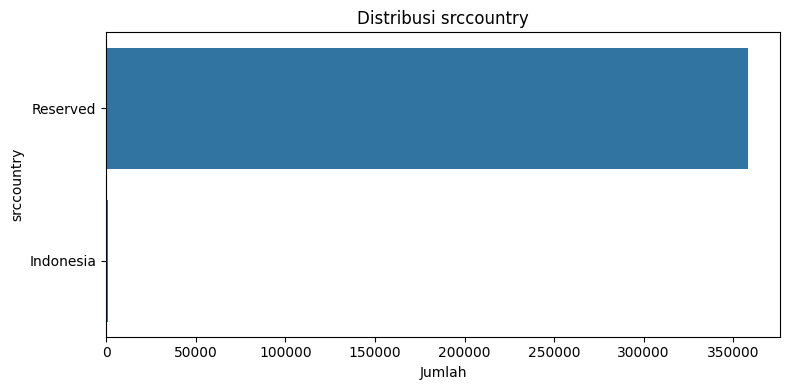


Distribusi untuk kolom 'action':
action
accept     49.734855
timeout    31.947512
ip-conn    18.317632
Name: proportion, dtype: float64


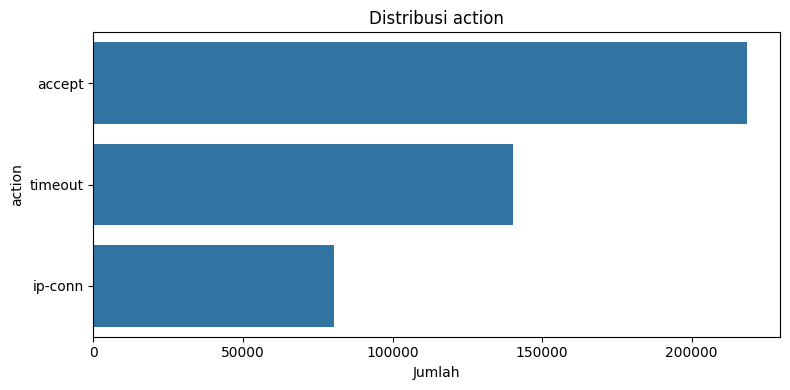


Distribusi untuk kolom 'proto':
proto
6     49.814933
17    49.064201
1      1.120866
Name: proportion, dtype: float64


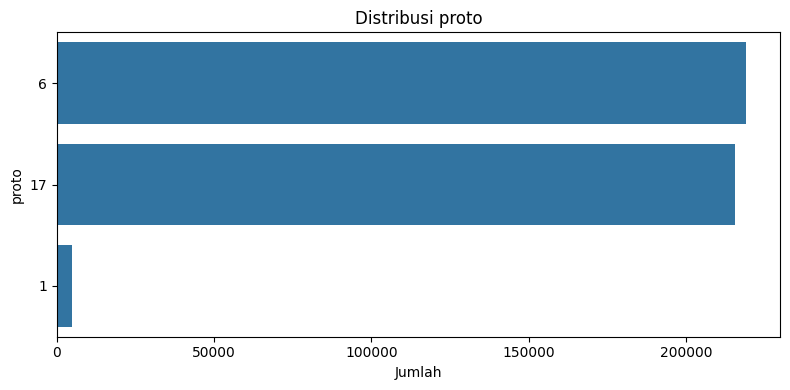


Distribusi untuk kolom 'service':
service
udp/53            48.927022
NaN               18.317632
tcp/2049          13.398063
rsyslog            6.510666
tcp/601            6.509984
SSH                5.439167
icmp/8/0           0.670654
udp/123            0.109197
HTTPS-WebAdmin     0.066201
tcp/53             0.020247
Name: proportion, dtype: float64


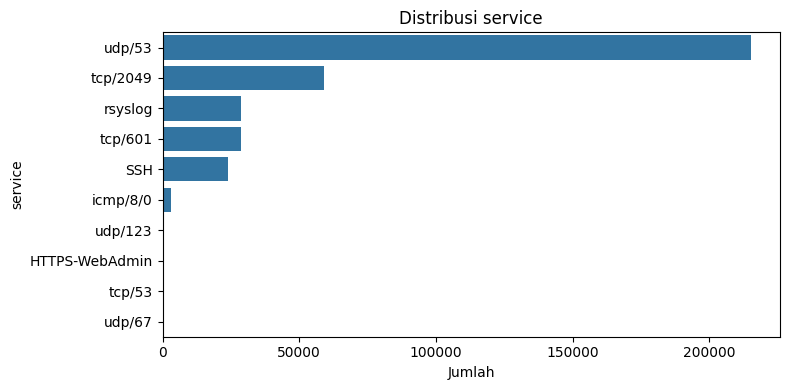


Distribusi untuk kolom 'level':
level
notice     81.682368
warning    18.317632
Name: proportion, dtype: float64


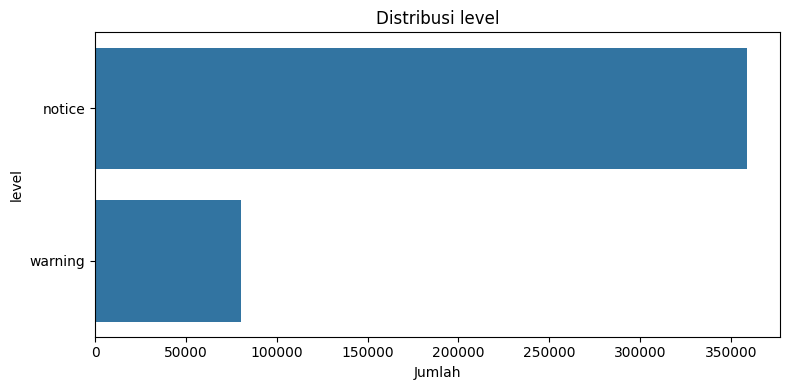


Distribusi untuk kolom 'app':
app
Domain Name Server    48.874471
NaN                   37.740888
rsyslog                6.510666
tcp/601                6.509984
icmp/8/0               0.154014
udp/123                0.109197
udp/53                 0.072798
DHCP/DHCP Relay        0.015242
udp/500                0.011830
L2TP                   0.000455
Name: proportion, dtype: float64


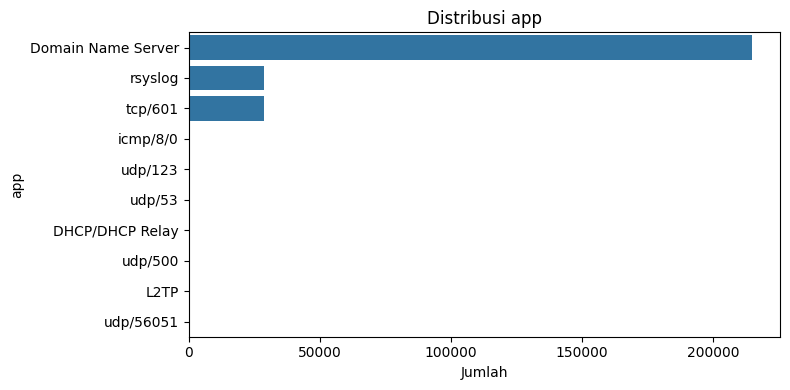


Distribusi untuk kolom 'appcat':
appcat
unscanned    100.0
Name: proportion, dtype: float64


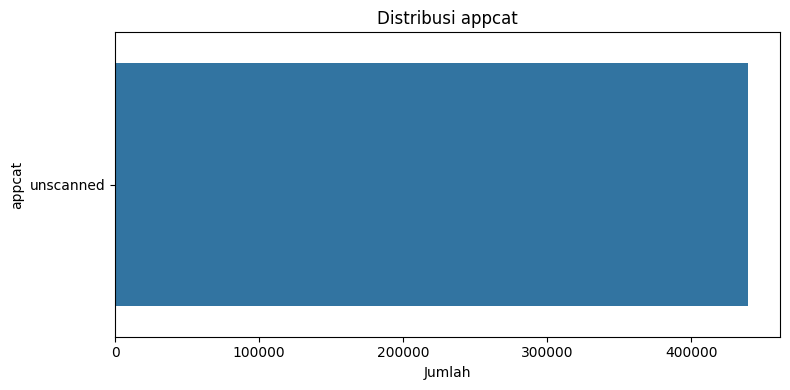


Distribusi untuk kolom 'crlevel':
crlevel
low    50.265145
NaN    49.734855
Name: proportion, dtype: float64


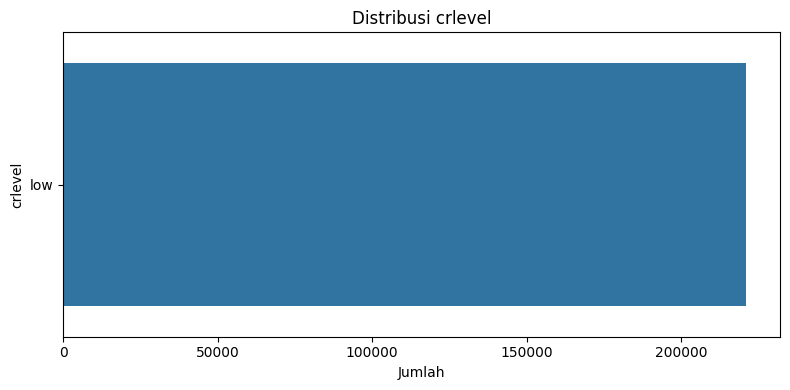


Distribusi untuk kolom 'policyid':
policyid
0      62.259112
16     37.738841
110     0.002047
Name: proportion, dtype: float64


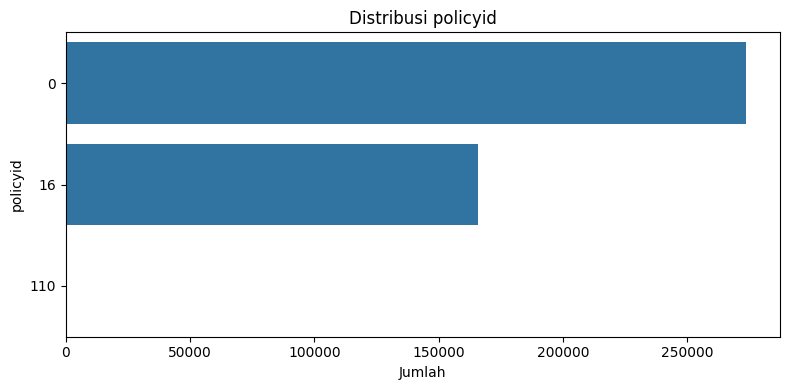


Distribusi untuk kolom 'policytype':
policytype
local-in-policy    49.026437
policy             37.740888
NaN                13.232675
Name: proportion, dtype: float64


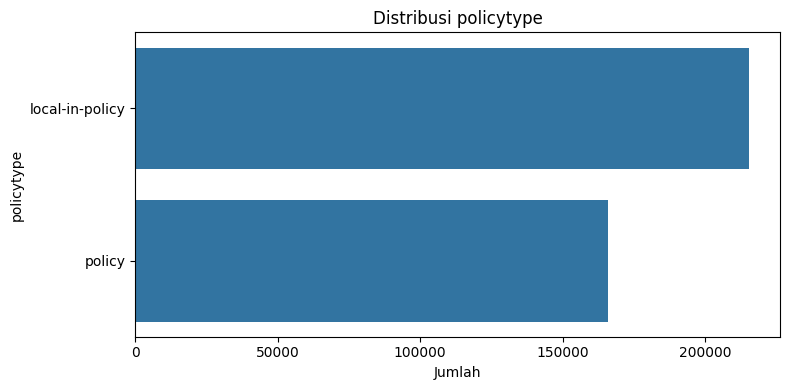


Distribusi untuk kolom 'subtype':
subtype
local      62.259112
forward    37.740888
Name: proportion, dtype: float64


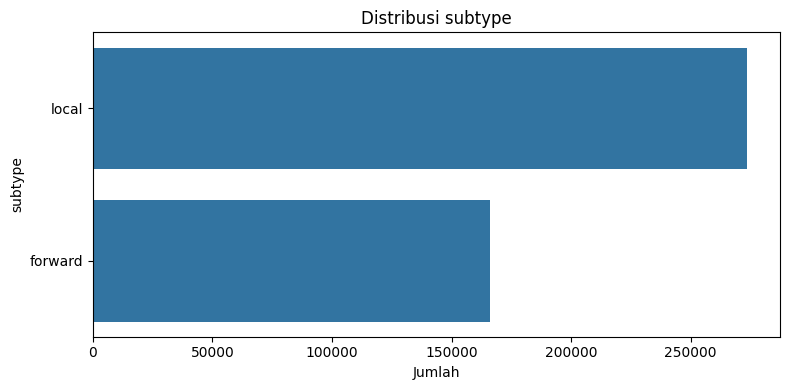


Distribusi untuk kolom 'dstcountry':
dstcountry
Reserved         81.486950
NaN              18.317632
Canada            0.109197
United States     0.072798
Indonesia         0.013422
Name: proportion, dtype: float64


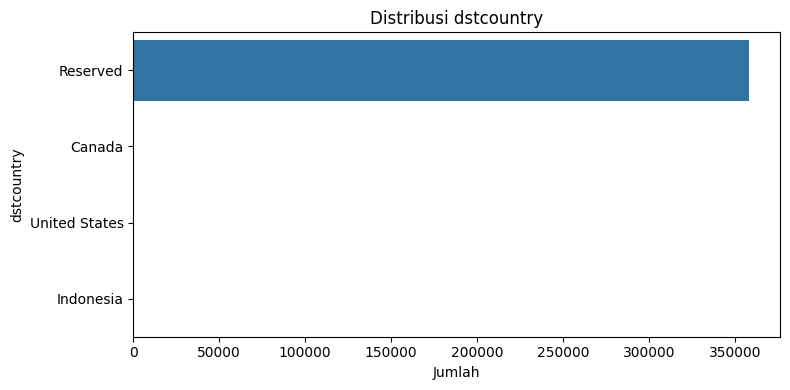


Distribusi untuk kolom 'srcintf':
srcintf
internal1    83.293029
unknown-0    13.051361
internal3     3.414693
root          0.195418
internal4     0.043906
wan2          0.001592
Name: proportion, dtype: float64


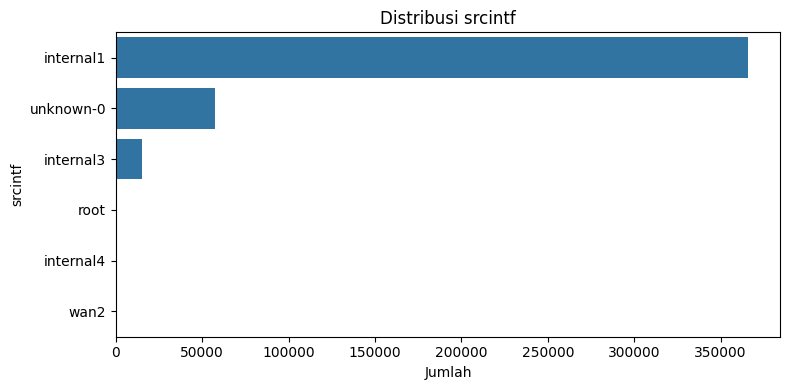


Distribusi untuk kolom 'dstintf':
dstintf
internal4      50.735149
root           49.026210
wan2            0.193825
unknown-0       0.024569
internal3       0.010010
internal1       0.008190
IPSec-Aesir     0.002047
Name: proportion, dtype: float64


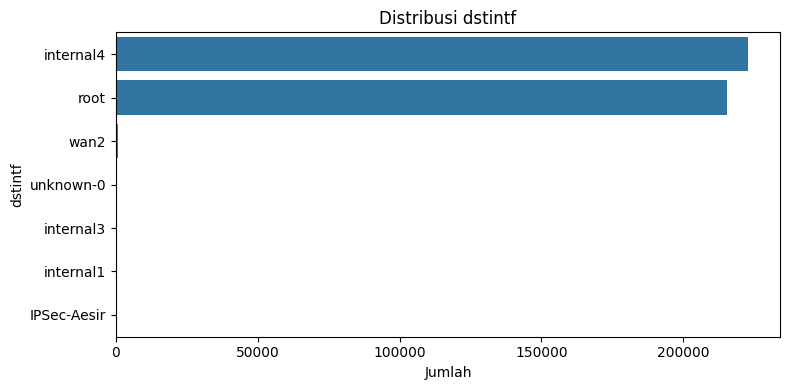


Distribusi untuk kolom 'vd':
vd
root    100.0
Name: proportion, dtype: float64


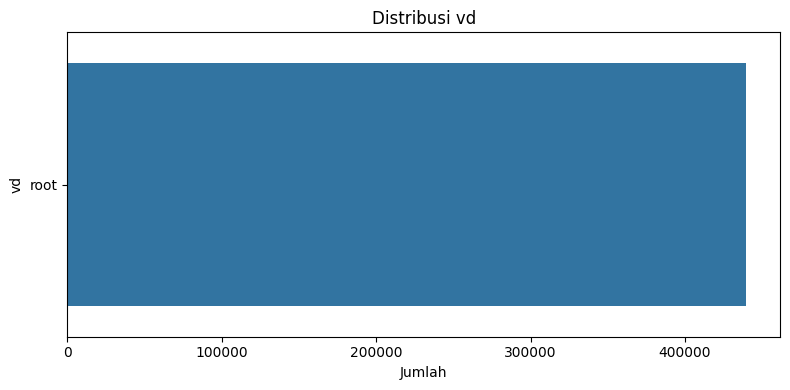


Distribusi untuk kolom 'type':
type
traffic    100.0
Name: proportion, dtype: float64


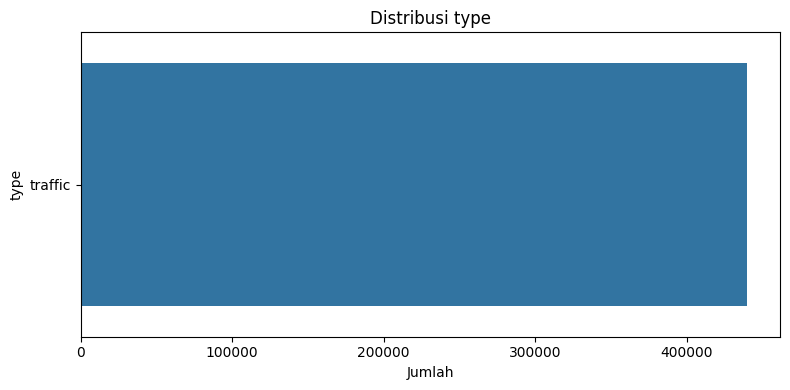


Distribusi untuk kolom 'trandisp':
trandisp
noop    81.682368
NaN     18.317632
Name: proportion, dtype: float64


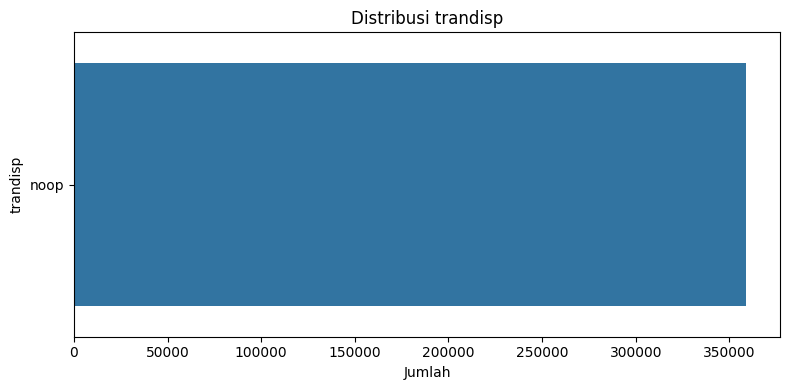


Distribusi untuk kolom 'devname':
devname
scientia_potentia_est    100.0
Name: proportion, dtype: float64


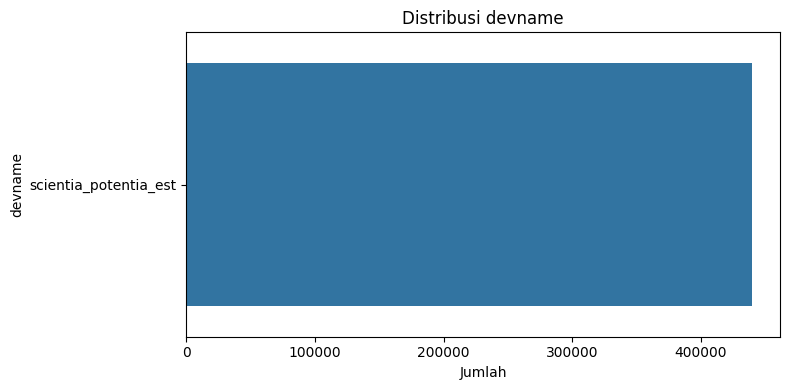


--- Statistik Deskriptif untuk Fitur Numerik ---
              count          mean            std          min          25%  \
duration   359052.0  1.358001e+02      61.171764         61.0         64.0   
sentbyte   359052.0  1.171377e+02     337.981744         28.0         74.0   
rcvdbyte   359052.0  1.622234e+02     665.622257          0.0        120.0   
sentpkt    359052.0  1.749479e+00       3.888614          1.0          1.0   
rcvdpkt    359052.0  1.477722e+00       3.783121          0.0          1.0   
crscore    220951.0  5.000000e+00       0.000000          5.0          5.0   
srcport    434644.0  3.081959e+04   22455.071827         53.0       1007.0   
dstport    434644.0  6.369073e+02     859.923352         22.0         53.0   
sessionid  439571.0  2.603823e+08  664413.870442  259273294.0  259811456.0   

                   50%          75%          max  
duration         181.0        181.0       1978.0  
sentbyte          78.0        120.0      84816.0  
rcvdbyte        

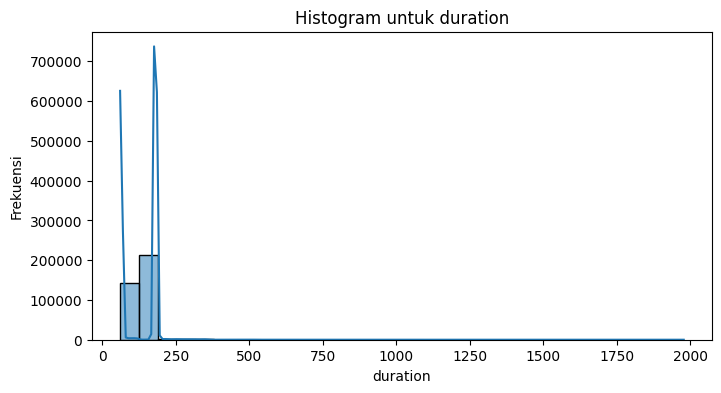

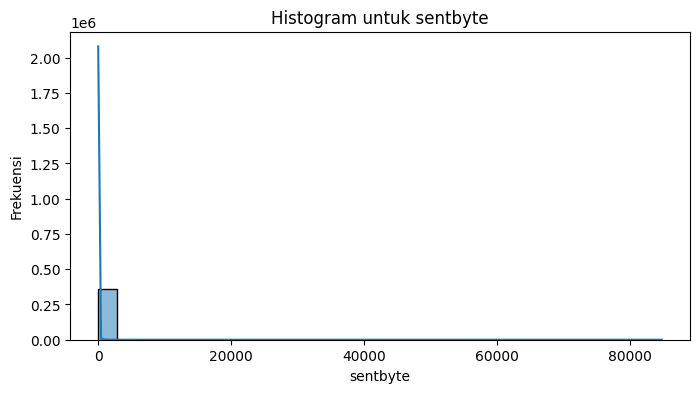

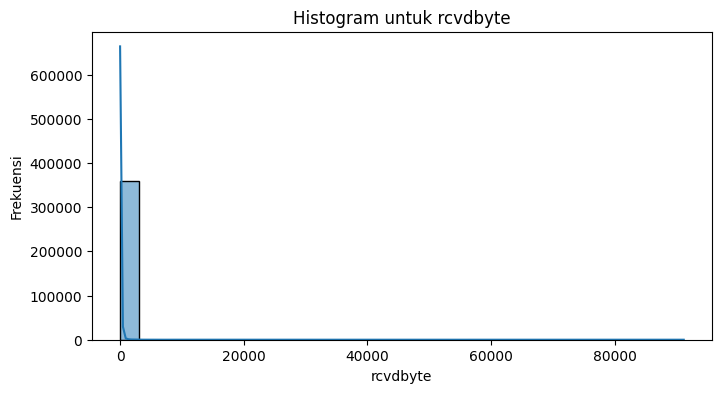

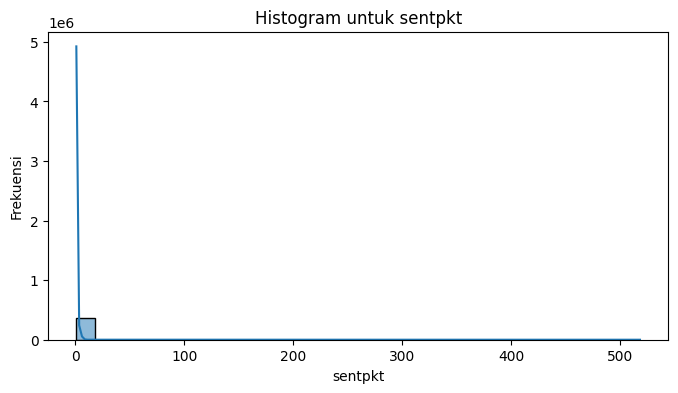

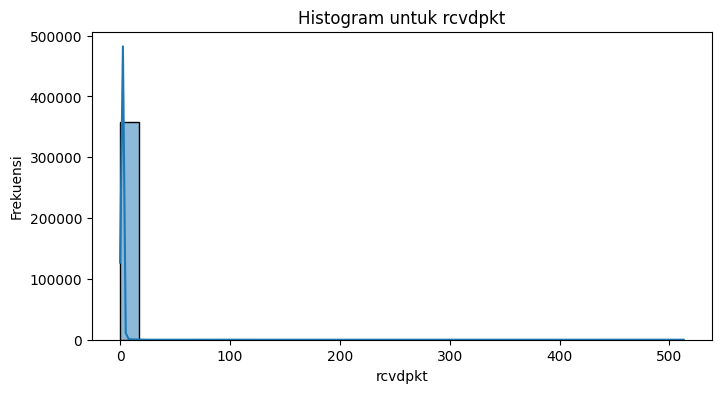

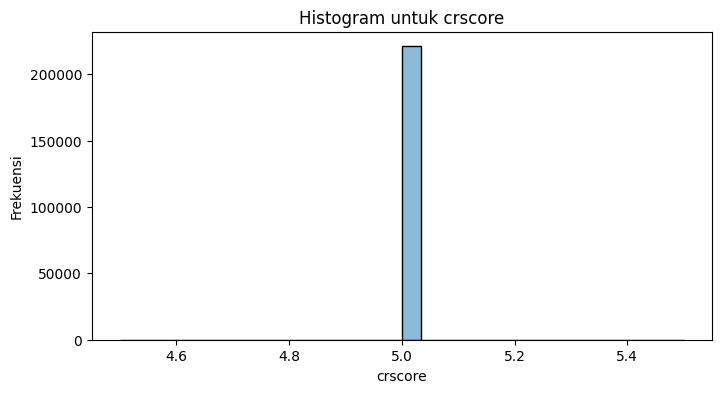

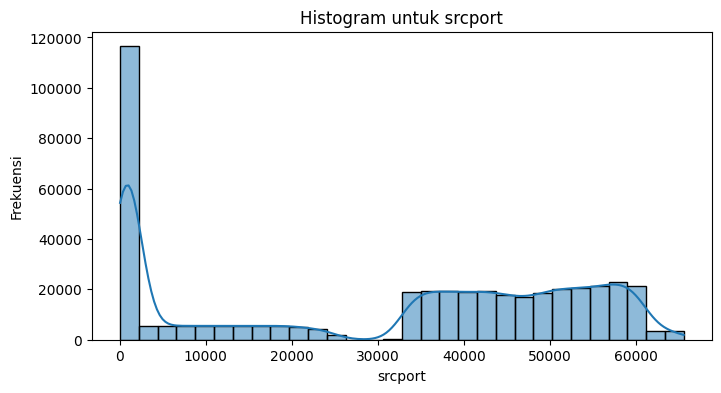

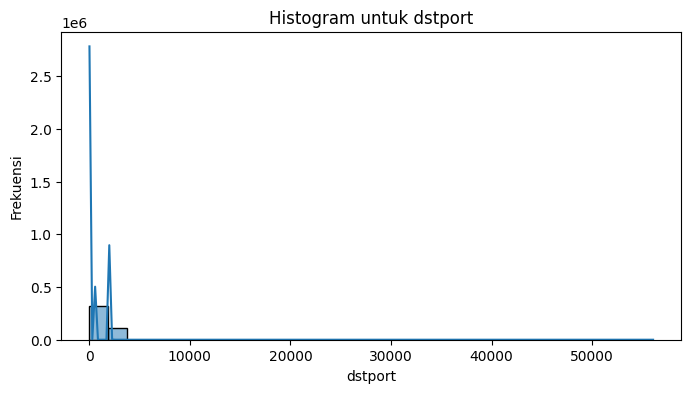

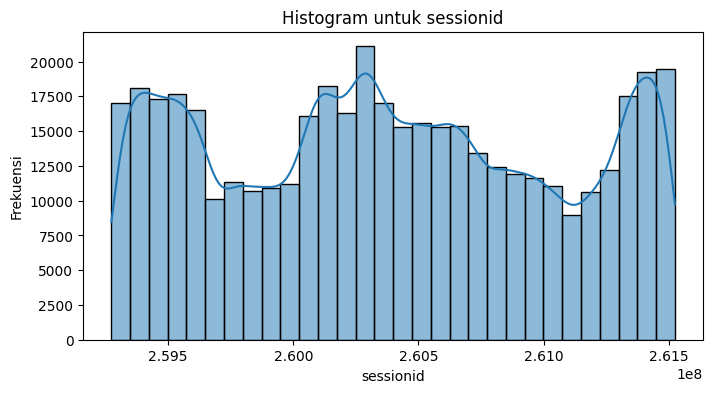


✅ EDA pada data training normal selesai.


In [3]:
# =============================================================================
# ### 3. Info Awal df_logs (Opsional)
# =============================================================================
if 'df_logs' not in locals() or df_logs.empty:
    print("⚠️ DataFrame 'df_logs' tidak ada atau kosong. EDA tidak dapat dilakukan.")
else:
    print("\n\n=============================================================================")
    print("### 3. Exploratory Data Analysis (EDA) pada Data Training Normal ###")
    print("=============================================================================")

    print(f"\nJumlah total log dalam data training normal: {len(df_logs)}")

    print("\n📋 Beberapa baris pertama data (df_logs.head()):")
    print(df_logs.head())

    print("\nℹ️ Informasi DataFrame (df_logs.info()):")
    df_logs.info()

    print(f"\n🔍 Jumlah baris duplikat: {df_logs.duplicated().sum()}")
    # Jika Anda ingin langsung menghapus duplikat di sini:
    # if df_logs.duplicated().sum() > 0:
    #     df_logs.drop_duplicates(inplace=True)
    #     df_logs.reset_index(drop=True, inplace=True)
    #     print(f"   Jumlah baris setelah menghapus duplikat: {len(df_logs)}")

    print("\n📊 Persentase nilai yang hilang per kolom:")
    missing_percentage = (df_logs.isnull().sum() / len(df_logs)) * 100
    print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

    # Definisikan kolom kategorikal dan numerik yang relevan untuk EDA
    # Ini harusnya sama dengan kolom yang akan Anda gunakan di Sel Pra-pemrosesan berikutnya
    # Ambil dari definisi fitur di sel pra-pemrosesan Anda jika sudah ada
    # Untuk contoh, saya akan definisikan ulang di sini berdasarkan diskusi kita
    
    # Kolom yang akan dianalisis sebagai kategorikal (nama kolom asli dari df_logs)
    eda_categorical_cols = [
        'srcip', 'srccountry', 'action', 'proto', 'service', 'level', 'app', 
        'appcat', 'crlevel', 'policyid', 'policytype', 'subtype', 'dstcountry', 
        'srcintf', 'dstintf', 'vd', 'type', 'trandisp', 'devname'
    ]
    # Filter hanya kolom yang ada di df_logs
    eda_categorical_cols = [col for col in eda_categorical_cols if col in df_logs.columns]

    # Kolom yang akan dianalisis sebagai numerik (nama kolom asli dari df_logs)
    eda_numerical_cols = [
        'duration', 'sentbyte', 'rcvdbyte', 'sentpkt', 'rcvdpkt', 
        'crscore', 'srcport', 'dstport', 'sessionid'
    ]
    eda_numerical_cols = [col for col in eda_numerical_cols if col in df_logs.columns]

    print("\n--- Distribusi Fitur Kategorikal (Top 10 Nilai) ---")
    for col in eda_categorical_cols:
        print(f"\nDistribusi untuk kolom '{col}':")
        # Tampilkan persentase untuk pemahaman yang lebih baik
        print(df_logs[col].value_counts(normalize=True, dropna=False).head(10) * 100)
        # Tambahkan plot jika diinginkan (misalnya untuk beberapa kolom utama)
        if df_logs[col].nunique() < 20: # Hanya plot jika jumlah nilai unik tidak terlalu banyak
            plt.figure(figsize=(8, 4))
            sns.countplot(y=df_logs[col], order = df_logs[col].value_counts().index[:10]) # Top 10
            plt.title(f'Distribusi {col}')
            plt.xlabel('Jumlah')
            plt.ylabel(col)
            plt.tight_layout()
            plt.show()
            
    print("\n--- Statistik Deskriptif untuk Fitur Numerik ---")
    if eda_numerical_cols:
        # Pastikan kolom numerik benar-benar numerik sebelum describe, tangani error jika ada
        df_eda_num_descriptive = pd.DataFrame()
        for col in eda_numerical_cols:
            df_eda_num_descriptive[col] = pd.to_numeric(df_logs[col], errors='coerce')
        
        print(df_eda_num_descriptive.describe().T) # .T untuk transpose agar lebih mudah dibaca

        # Opsional: Plot histogram untuk fitur numerik
        print("\n--- Histogram Fitur Numerik ---")
        for col in eda_numerical_cols:
            plt.figure(figsize=(8, 4))
            # Filter out NaNs yang mungkin muncul dari to_numeric jika ada nilai yang tidak bisa dikonversi
            # meskipun idealnya data training sudah bersih dari ini atau NaN ditangani.
            feature_data = pd.to_numeric(df_logs[col], errors='coerce').dropna()
            if not feature_data.empty:
                 sns.histplot(feature_data, kde=True, bins=30)
                 plt.title(f'Histogram untuk {col}')
                 plt.xlabel(col)
                 plt.ylabel('Frekuensi')
                 plt.show()
            else:
                print(f"Tidak ada data numerik valid untuk diplot pada kolom {col}.")
    else:
        print("Tidak ada fitur numerik yang valid untuk ditampilkan statistiknya.")

    print("\n✅ EDA pada data training normal selesai.")

In [4]:
# train_script.ipynb - Sel Pra-pemrosesan Data (setelah df_logs dimuat)

import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import joblib
import os
import numpy as np

# Pastikan df_logs sudah ada dari sel sebelumnya dan tidak kosong
if 'df_logs' not in locals() or df_logs.empty:
    print("❌ DataFrame 'df_logs' tidak ditemukan atau kosong. Hentikan proses.")
    raise NameError("df_logs tidak terdefinisi atau kosong.")

print(f"\nMemulai pra-pemrosesan untuk {len(df_logs)} baris log normal training...")

# === 1. DEFINISIKAN FITUR YANG AKAN DIGUNAKAN (BERDASARKAN SELEKSI) ===
# Nama kolom asli dari df_logs
selected_categorical_features = [
    'srccountry', 'dstcountry', 'action', 'proto', 'service', 'level', 'app', 
    'policyid', 'policytype', 'subtype', 'srcintf', 'dstintf', 'type', 'crlevel', 'trandisp', 'vd' 
]
selected_numerical_features = [
    'duration', 'sentbyte', 'rcvdbyte', 'sentpkt', 'rcvdpkt', 
    'srcport', 'dstport'
]

# Filter berdasarkan kolom yang benar-benar ada di df_logs
available_categorical_original = sorted([f for f in selected_categorical_features if f in df_logs.columns])
available_numerical_original = sorted([f for f in selected_numerical_features if f in df_logs.columns])

print(f"\nFitur Kategorikal Terpilih yang akan diproses: {available_categorical_original}")
print(f"Jumlah: {len(available_categorical_original)}")
print(f"Fitur Numerik Terpilih yang akan diproses: {available_numerical_original}")
print(f"Jumlah: {len(available_numerical_original)}")

# Hapus fitur yang tidak ada dari daftar utama jika perlu (meskipun filtering di atas sudah menangani)
# Ini lebih untuk memastikan daftar yang disimpan ke feature_types.pkl akurat
final_categorical_to_process = available_categorical_original
final_numerical_to_process = available_numerical_original


# === 2. PROSES FITUR KATEGORIKAL ===
df_cat_processed = pd.DataFrame(index=df_logs.index)
label_encoders = {}
if final_categorical_to_process:
    print("\n--- Memproses Fitur Kategorikal Terpilih ---")
    for col in final_categorical_to_process:
        s = df_logs[col].astype(str).fillna('Unknown').replace('', 'Unknown')
        le = LabelEncoder()
        df_cat_processed[col] = le.fit_transform(s)
        label_encoders[col] = le
    print(f"✅ Fitur kategorikal ({len(final_categorical_to_process)} kolom) telah di-encode.")
else:
    print("ℹ️ Tidak ada fitur kategorikal yang terpilih/tersedia untuk diproses.")

# === 3. PROSES FITUR NUMERIK ===
df_num_processed = pd.DataFrame(index=df_logs.index)
if final_numerical_to_process:
    print("\n--- Memproses Fitur Numerik Terpilih ---")
    for col in final_numerical_to_process:
        s_num = pd.to_numeric(df_logs[col], errors='coerce')
        median_val = s_num.median()
        s_num_filled = s_num.fillna(median_val if pd.notna(median_val) else 0)
        df_num_processed[col] = s_num_filled
    print(f"✅ Fitur numerik ({len(final_numerical_to_process)} kolom) telah diproses.")
else:
    print("ℹ️ Tidak ada fitur numerik yang terpilih/tersedia untuk diproses.")

# === 4. GABUNGKAN FITUR ===
df_list_to_concat = []
if not df_cat_processed.empty: df_list_to_concat.append(df_cat_processed[final_categorical_to_process])
if not df_num_processed.empty: df_list_to_concat.append(df_num_processed[final_numerical_to_process])
    
df_combined_processed = pd.DataFrame()
if df_list_to_concat: df_combined_processed = pd.concat(df_list_to_concat, axis=1)
    
df_combined_processed_cols = []
if df_combined_processed.empty:
    print("\n❌ DataFrame gabungan kosong. Tidak ada fitur yang bisa diproses lebih lanjut.")
    df_processed = pd.DataFrame()
else:
    df_combined_processed_cols = df_combined_processed.columns.tolist() # Ini adalah urutan final untuk scaler
    print(f"\n✅ Fitur telah digabungkan. Total fitur: {df_combined_processed.shape[1]}.")
    print(f"Urutan kolom untuk scaler: {df_combined_processed_cols}")
    
    # === 5. SCALING ===
    print("\n⏳ Menerapkan MinMaxScaler...")
    scaler = MinMaxScaler()
    df_scaled_values = scaler.fit_transform(df_combined_processed)
    df_processed = pd.DataFrame(df_scaled_values, columns=df_combined_processed_cols, index=df_combined_processed.index)
    print("✅ Semua fitur telah diskalakan.")
    print("\n📋 Pratinjau DataFrame Siap Latih (df_processed):")
    print(df_processed.head())
    df_processed.info()

# Inisialisasi fallback
if 'df_processed' not in locals(): df_processed = pd.DataFrame()
if 'label_encoders' not in locals(): label_encoders = {}
if 'scaler' not in locals(): scaler = None
# available_categorical_original_selected dan available_numerical_original_selected diganti menjadi final_...
if 'final_categorical_to_process' not in locals(): final_categorical_to_process = []
if 'final_numerical_to_process' not in locals(): final_numerical_to_process = []
if 'df_combined_processed_cols' not in locals(): df_combined_processed_cols = []


# === 6. SIMPAN ARTEFAK PRA-PEMROSESAN (PENTING!) ===
# Pindahkan penyimpanan artefak ke sini agar variabelnya terdefinisi dengan benar
# bahkan jika df_combined_processed tidak kosong tapi proses setelahnya ada masalah.
# Sel ini HARUS dijalankan sampai selesai untuk menghasilkan artefak yang benar.

output_dir_artifacts = 'trained_models_artifacts'
os.makedirs(output_dir_artifacts, exist_ok=True)

print(f"\n📁 Menyimpan artefak pra-pemrosesan yang relevan ke: {output_dir_artifacts}")

if label_encoders: 
    le_path = os.path.join(output_dir_artifacts, 'label_encoders.pkl')
    joblib.dump(label_encoders, le_path)
    print(f"💾 Label Encoders disimpan ke: {le_path} (Total: {len(label_encoders)} encoders untuk fitur: {list(label_encoders.keys())})")
else:
    print("ℹ️ Tidak ada Label Encoders untuk disimpan.")

if scaler is not None: 
    sc_path = os.path.join(output_dir_artifacts, 'scaler.pkl')
    joblib.dump(scaler, sc_path)
    print(f"💾 Scaler disimpan ke: {sc_path}")
else:
    print("ℹ️ Tidak ada Scaler untuk disimpan (kemungkinan pra-pemrosesan tidak sampai tahap scaling atau tidak ada fitur).")

if df_combined_processed_cols: 
    model_cols_path = os.path.join(output_dir_artifacts, 'model_columns.pkl')
    joblib.dump(df_combined_processed_cols, model_cols_path)
    print(f"💾 Daftar kolom model (untuk scaler) disimpan ke: {model_cols_path} ({len(df_combined_processed_cols)} kolom)")
else:
    print("ℹ️ Tidak ada daftar kolom model untuk disimpan.")

feature_types_to_save = {
    'categorical_original_names': final_categorical_to_process, # Gunakan list fitur yang benar-benar diproses
    'numerical_original_names': final_numerical_to_process   # Gunakan list fitur yang benar-benar diproses
}
if feature_types_to_save['categorical_original_names'] or feature_types_to_save['numerical_original_names']:
    ft_path = os.path.join(output_dir_artifacts, 'feature_types.pkl')
    joblib.dump(feature_types_to_save, ft_path)
    print(f"💾 Tipe fitur (nama kolom asli terpilih) disimpan ke: {ft_path}")
else:
    print("ℹ️ Tidak ada tipe fitur untuk disimpan.")

print("\n✨ Penyimpanan artefak pra-pemrosesan dari sel ini selesai.")


Memulai pra-pemrosesan untuk 439571 baris log normal training...

Fitur Kategorikal Terpilih yang akan diproses: ['action', 'app', 'crlevel', 'dstcountry', 'dstintf', 'level', 'policyid', 'policytype', 'proto', 'service', 'srccountry', 'srcintf', 'subtype', 'trandisp', 'type', 'vd']
Jumlah: 16
Fitur Numerik Terpilih yang akan diproses: ['dstport', 'duration', 'rcvdbyte', 'rcvdpkt', 'sentbyte', 'sentpkt', 'srcport']
Jumlah: 7

--- Memproses Fitur Kategorikal Terpilih ---
✅ Fitur kategorikal (16 kolom) telah di-encode.

--- Memproses Fitur Numerik Terpilih ---
✅ Fitur numerik (7 kolom) telah diproses.

✅ Fitur telah digabungkan. Total fitur: 23.
Urutan kolom untuk scaler: ['action', 'app', 'crlevel', 'dstcountry', 'dstintf', 'level', 'policyid', 'policytype', 'proto', 'service', 'srccountry', 'srcintf', 'subtype', 'trandisp', 'type', 'vd', 'dstport', 'duration', 'rcvdbyte', 'rcvdpkt', 'sentbyte', 'sentpkt', 'srcport']

⏳ Menerapkan MinMaxScaler...
✅ Semua fitur telah diskalakan.

📋 Prat


--- Melatih Model Autoencoder ---
Arsitektur AE: Input(23) -> Dense(17) -> Dropout(0.2) -> Dense(11) [Bottleneck] -> Dense(17) -> Dropout(0.2) -> Output(23)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 23)             │           299 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 799 (3.12 KB)

 Trainable params: 799 (3.12 KB)

 Non-trainable params: 0 (0.00 B)


⏳ Memulai pelatihan Autoencoder...
Epoch 1/50
10968/10990 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.0218
Epoch 1: val_loss improved from inf to 0.00187, saving model to trained_models_artifacts\autoencoder_model.keras
10990/10990 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0218 - val_loss: 0.0019
Epoch 2/50
10972/10990 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0036
Epoch 2: val_loss did not improve from 0.00187
10990/10990 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 3/50
10987/10990 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 0.0030
Epoch 3: val_loss did not improve from 0.00187
10990/10990 ━━━━━━━━━━━━━━━━━━━━ 11s 997us/step - loss: 0.0030 - val_loss: 0.0022
Epoch 4/50
10963/10990 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 0.0029
Epoch 4: val_loss improved from 0.00187 to 0.00177, saving model to trained_models_artifacts\autoencoder_model.keras
10990/10990 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 5/50
10980/10990 ━━━

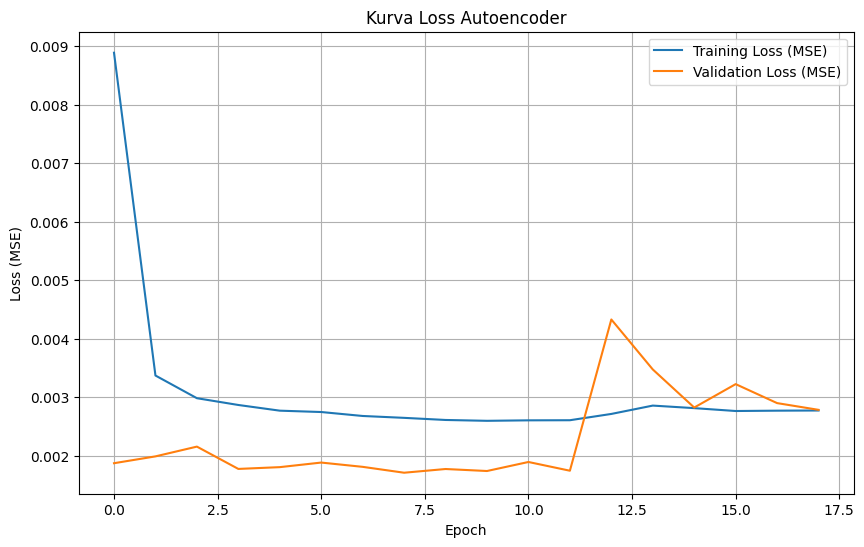

In [5]:
# =============================================================================
# ### 5. Melatih Model Autoencoder 🤖
# =============================================================================
autoencoder = None 
history_ae = None 
if df_processed.empty:
    print("\n❌ DataFrame 'df_processed' kosong. Tidak dapat melatih Autoencoder.")
else:
    print("\n--- Melatih Model Autoencoder ---")
    input_dim_ae = df_processed.shape[1]
    if input_dim_ae == 0:
        print("❌ Dimensi input Autoencoder adalah 0. Tidak bisa melatih.")
    else:
        # Arsitektur Autoencoder (contoh, sesuaikan dengan jumlah fitur baru Anda)
        # Anda bisa membuat ini lebih dinamis atau menetapkannya berdasarkan input_dim_ae
        l1_nodes = max(10, int(input_dim_ae * 0.75)) if input_dim_ae > 0 else 10
        l2_nodes_bottleneck = max(8, int(input_dim_ae * 0.50)) if input_dim_ae > 0 else 8
        if l2_nodes_bottleneck >= l1_nodes and l1_nodes > 1 : l2_nodes_bottleneck = max(4, int(l1_nodes/2))


        print(f"Arsitektur AE: Input({input_dim_ae}) -> Dense({l1_nodes}) -> Dropout(0.2) -> Dense({l2_nodes_bottleneck}) [Bottleneck] -> Dense({l1_nodes}) -> Dropout(0.2) -> Output({input_dim_ae})")
        
        input_layer_ae = Input(shape=(input_dim_ae,))
        encoder = Dense(12, activation="relu")(input_layer_ae) # Layer lebih lebar dari 8
        encoder = Dropout(0.2)(encoder)
        encoder = Dense(8, activation="relu")(encoder) # Bottleneck lebih lebar dari 4

        decoder = Dense(12, activation="relu")(encoder) # Layer lebih lebar dari 8
        decoder = Dropout(0.2)(decoder)
        decoder_output = Dense(input_dim_ae, activation='sigmoid')(decoder)
        
        autoencoder = Model(inputs=input_layer_ae, outputs=decoder_output)
        autoencoder.compile(optimizer='adam', loss='mse') # mse adalah singkatan dari mean_squared_error
        autoencoder.summary()
        
        output_dir_models = 'trained_models_artifacts'
        os.makedirs(output_dir_models, exist_ok=True) # Pastikan folder ada
        autoencoder_save_path = os.path.join(output_dir_models, 'autoencoder_model.keras')
        
        early_stopping_ae = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        model_checkpoint_ae = ModelCheckpoint(filepath=autoencoder_save_path, save_best_only=True, monitor='val_loss', verbose=1)
        
        print("\n⏳ Memulai pelatihan Autoencoder...")
        history_ae = autoencoder.fit(df_processed, df_processed, 
                                  epochs=50, # Kurangi epoch untuk iterasi lebih cepat, bisa dinaikkan lagi
                                  batch_size=32, # Batch size lebih kecil mungkin membantu generalisasi
                                  shuffle=True, 
                                  validation_split=0.2, 
                                  callbacks=[early_stopping_ae, model_checkpoint_ae], 
                                  verbose=1)
        print("\n✅ Pelatihan Autoencoder Selesai.")
        
        print(f"Memuat model Autoencoder terbaik dari: {autoencoder_save_path}")
        try:
            autoencoder = load_model(autoencoder_save_path) 
            print("✅ Model terbaik Autoencoder berhasil dimuat ulang.")
        except Exception as e:
            print(f"⚠️ Gagal memuat model terbaik dari checkpoint: {e}. Model terakhir dari .fit() akan digunakan.")
        
        plt.figure(figsize=(10,6))
        plt.plot(history_ae.history['loss'], label='Training Loss (MSE)')
        plt.plot(history_ae.history['val_loss'], label='Validation Loss (MSE)')
        plt.title('Kurva Loss Autoencoder'); plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)'); plt.legend(); plt.grid(True); plt.show()


In [6]:
# =============================================================================
# ### 6. Penyimpanan MSE Training Autoencoder
# =============================================================================
mse_train_ae = np.array([]) # Inisialisasi sebagai array kosong
if autoencoder is not None and not df_processed.empty:
    print("\n--- Menghitung dan Menyimpan Reconstruction Error (MSE) Training Autoencoder ---")
    reconstructions_ae = autoencoder.predict(df_processed)
    # Pastikan df_processed adalah numpy array atau konversi jika masih DataFrame
    df_processed_np = df_processed.to_numpy() if isinstance(df_processed, pd.DataFrame) else df_processed
    mse_train_ae = np.mean(np.power(df_processed_np - reconstructions_ae, 2), axis=1)
    
    output_dir_artifacts = 'trained_models_artifacts' # Pastikan ini konsisten
    os.makedirs(output_dir_artifacts, exist_ok=True)
    mse_training_save_path = os.path.join(output_dir_artifacts, 'training_mse_ae.npy')
    try:
        np.save(mse_training_save_path, mse_train_ae)
        print(f"💾 Training MSE Autoencoder berhasil disimpan ke: {mse_training_save_path}")
    except Exception as e:
        print(f"❌ Gagal menyimpan Training MSE Autoencoder: {e}")

    # Visualisasi distribusi MSE training (opsional di sini, karena sudah ada di dashboard)
    # threshold_ae_train = np.percentile(mse_train_ae, 95) 
    # plt.figure(figsize=(10,6)); sns.histplot(mse_train_ae, bins=50, kde=True); plt.axvline(threshold_ae_train, color='r', linestyle='--'); plt.title('Distribusi MSE Training AE'); plt.show()
    # print(f"Contoh threshold (95-percentile) dari MSE training: {threshold_ae_train:.6f}")
else:
    print("\n⚠️ Autoencoder tidak dilatih atau df_processed kosong, MSE training tidak dihitung/disimpan.")



--- Menghitung dan Menyimpan Reconstruction Error (MSE) Training Autoencoder ---
13737/13737 ━━━━━━━━━━━━━━━━━━━━ 7s 505us/step
💾 Training MSE Autoencoder berhasil disimpan ke: trained_models_artifacts\training_mse_ae.npy


In [7]:
# train_script.ipynb

# Sel 7: Melatih Model One-Class SVM
# =============================================================================
# ### 7. Melatih Model One-Class SVM (OCSVM) 🛡️
# =============================================================================
import time # Tambahkan impor time jika belum ada di sel impor utama

ocsvm = None # Inisialisasi
if df_processed.empty: # Pastikan df_processed dari sel pra-pemrosesan tidak kosong
    print("\n❌ DataFrame 'df_processed' kosong. Tidak dapat melatih One-Class SVM.")
else:
    print("\n--- Melatih Model One-Class SVM ---")
    
    # Parameter untuk OCSVM (Anda bisa menyesuaikan ini)
    ocsvm_kernel = 'rbf'
    ocsvm_gamma = 'auto' # atau 'scale', atau nilai float
    ocsvm_nu = 0.005      # Perkiraan proporsi anomali di data training / batas atas error

    print(f"Parameter OCSVM: kernel='{ocsvm_kernel}', gamma='{ocsvm_gamma}', nu={ocsvm_nu}, verbose=True")
    
    # Inisialisasi model dengan verbose=True
    ocsvm = OneClassSVM(kernel=ocsvm_kernel, gamma=ocsvm_gamma, nu=ocsvm_nu, verbose=True) 
    
    print(f"\n⏳ Memulai pelatihan OCSVM (fit)... Ini mungkin memerlukan waktu beberapa saat tergantung ukuran data.")
    start_time_ocsvm = time.time() # Catat waktu mulai
    
    try:
        ocsvm.fit(df_processed) # Dilatih hanya dengan data normal (df_processed)
        end_time_ocsvm = time.time() # Catat waktu selesai
        training_time_ocsvm = end_time_ocsvm - start_time_ocsvm
        
        print(f"✅ Pelatihan One-Class SVM Selesai. Waktu pelatihan: {training_time_ocsvm:.2f} detik.")
        
        # Tampilkan beberapa informasi dari model yang sudah dilatih
        if hasattr(ocsvm, 'n_support_'):
            print(f"   Jumlah Support Vectors: {ocsvm.n_support_.sum()} (dari {len(df_processed)} sampel data training)")
        if hasattr(ocsvm, 'offset_'):
             print(f"   Offset (intercept): {ocsvm.offset_[0]:.4f}")

        # Simpan model OCSVM
        output_dir_models = 'trained_models_artifacts' 
        os.makedirs(output_dir_models, exist_ok=True) # Pastikan folder ada
        ocsvm_save_path = os.path.join(output_dir_models, 'ocsvm_model.pkl')
        joblib.dump(ocsvm, ocsvm_save_path)
        print(f"💾 Model OCSVM berhasil disimpan ke: {ocsvm_save_path}")

    except Exception as e:
        print(f"❌ Terjadi error saat melatih atau menyimpan OCSVM: {e}")
        ocsvm = None # Set ocsvm ke None jika training gagal


--- Melatih Model One-Class SVM ---
Parameter OCSVM: kernel='rbf', gamma='auto', nu=0.005, verbose=True

⏳ Memulai pelatihan OCSVM (fit)... Ini mungkin memerlukan waktu beberapa saat tergantung ukuran data.
[LibSVM]✅ Pelatihan One-Class SVM Selesai. Waktu pelatihan: 2152.50 detik.
   Jumlah Support Vectors: 2202 (dari 439571 sampel data training)
   Offset (intercept): 1799.8112
💾 Model OCSVM berhasil disimpan ke: trained_models_artifacts\ocsvm_model.pkl


In [8]:
# =============================================================================
# ### 8. Menyimpan Semua Artefak Pra-pemrosesan (Final) 📦
# =============================================================================
output_dir_artifacts = 'trained_models_artifacts' 
os.makedirs(output_dir_artifacts, exist_ok=True)

print(f"\n📁 Menyimpan semua artefak pra-pemrosesan yang relevan ke: {output_dir_artifacts}")

if label_encoders: 
    le_path = os.path.join(output_dir_artifacts, 'label_encoders.pkl')
    joblib.dump(label_encoders, le_path)
    print(f"💾 Label Encoders disimpan ke: {le_path} (Total: {len(label_encoders)} encoders)")
else:
    print("ℹ️ Tidak ada Label Encoders untuk disimpan (kemungkinan tidak ada fitur kategorikal).")

if scaler is not None: 
    sc_path = os.path.join(output_dir_artifacts, 'scaler.pkl')
    joblib.dump(scaler, sc_path)
    print(f"💾 Scaler disimpan ke: {sc_path}")
else:
    print("ℹ️ Tidak ada Scaler untuk disimpan (kemungkinan pra-pemrosesan tidak sampai tahap scaling).")

if df_combined_processed_cols: 
    model_cols_path = os.path.join(output_dir_artifacts, 'model_columns.pkl')
    joblib.dump(df_combined_processed_cols, model_cols_path)
    print(f"💾 Daftar kolom model (untuk scaler) disimpan ke: {model_cols_path} ({len(df_combined_processed_cols)} kolom)")
else:
    print("ℹ️ Tidak ada daftar kolom model untuk disimpan.")

# Simpan feature_types jika ada (nama kolom asli kategorikal dan numerik)
feature_types_to_save = {
    'categorical_original_names': available_categorical_original if 'available_categorical_original' in locals() else [],
    'numerical_original_names': available_numerical_original if 'available_numerical_original' in locals() else []
}
if feature_types_to_save['categorical_original_names'] or feature_types_to_save['numerical_original_names']:
    ft_path = os.path.join(output_dir_artifacts, 'feature_types.pkl')
    joblib.dump(feature_types_to_save, ft_path)
    print(f"💾 Tipe fitur (nama kolom asli) disimpan ke: {ft_path}")
else:
    print("ℹ️ Tidak ada tipe fitur untuk disimpan.")

print("\n✨ Penyimpanan artefak pra-pemrosesan selesai.")


📁 Menyimpan semua artefak pra-pemrosesan yang relevan ke: trained_models_artifacts
💾 Label Encoders disimpan ke: trained_models_artifacts\label_encoders.pkl (Total: 16 encoders)
💾 Scaler disimpan ke: trained_models_artifacts\scaler.pkl
💾 Daftar kolom model (untuk scaler) disimpan ke: trained_models_artifacts\model_columns.pkl (23 kolom)
💾 Tipe fitur (nama kolom asli) disimpan ke: trained_models_artifacts\feature_types.pkl

✨ Penyimpanan artefak pra-pemrosesan selesai.




### Memulai Tahap Evaluasi Model ###

Memuat data normal untuk evaluasi dari: data/syslog_normal_tgl_01.log
Memuat data anomali untuk evaluasi dari: data/syslog_anomali_tgl_01.log
✅ Berhasil memuat 439571 baris data normal untuk evaluasi.
✅ Berhasil memuat 89992 baris data anomali untuk evaluasi.

Total data normal untuk evaluasi: 439571
Total data anomali untuk evaluasi: 89992
Total data gabungan untuk evaluasi: 529563

--- Melakukan Pra-pemrosesan pada Data Evaluasi Gabungan ---
✅ Pra-pemrosesan data evaluasi selesai.
Shape data evaluasi yang sudah di-scale: (529563, 23)


### Evaluasi Model Autoencoder pada Data Uji Berlabel ###

--- Metrik Evaluasi untuk Model: Autoencoder ---
  Precision: 0.7918
  Recall:    1.0000
  F1-Score:  0.8838
  ROC AUC:   0.9979


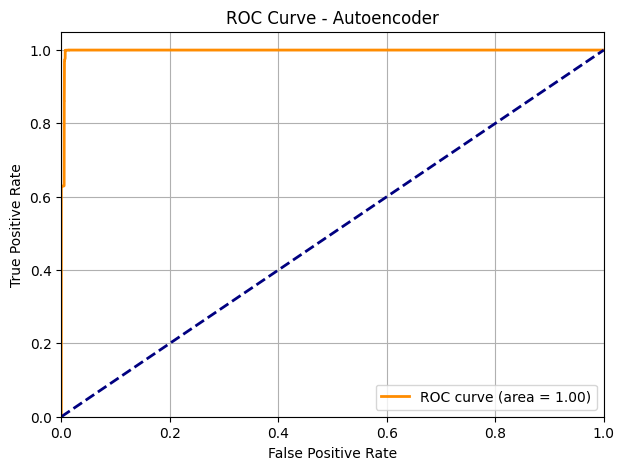


  Confusion Matrix:
[[415903  23668]
 [     0  89992]]


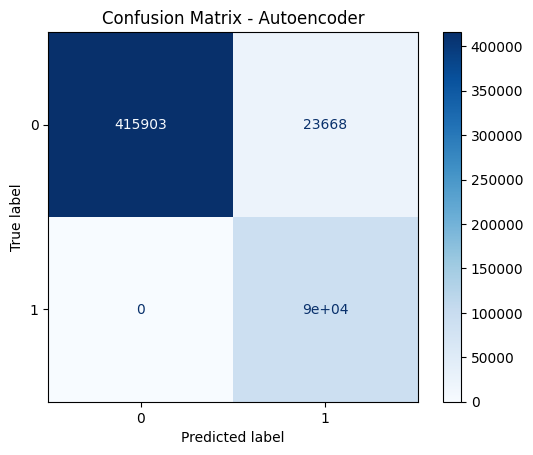



### Evaluasi Model One-Class SVM pada Data Uji Berlabel ###

--- Metrik Evaluasi untuk Model: One-Class SVM ---
  Precision: 0.6018
  Recall:    0.9973
  F1-Score:  0.7507
  ROC AUC:   0.9983


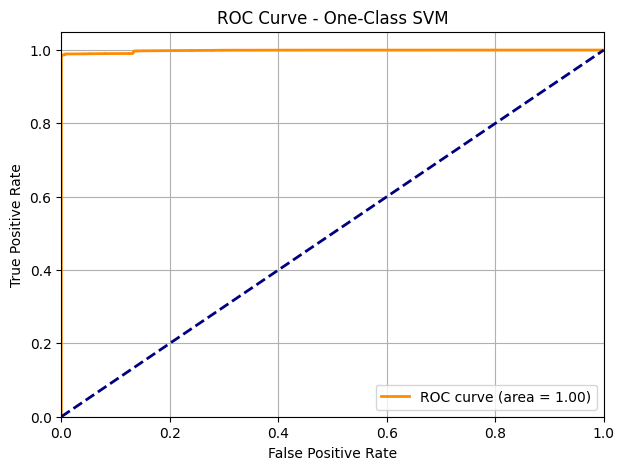


  Confusion Matrix:
[[380200  59371]
 [   247  89745]]


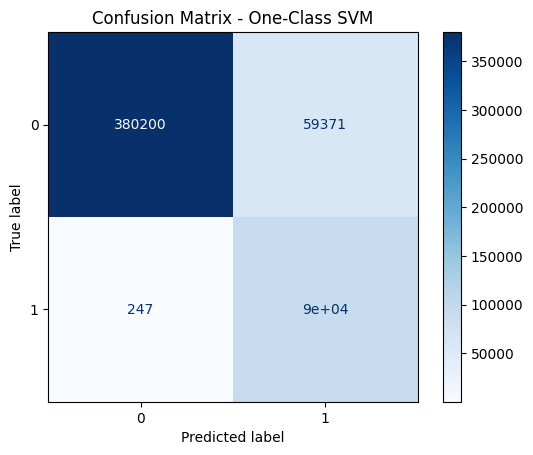



✅ Proses evaluasi model dengan data berlabel selesai.


In [9]:
# =============================================================================
# ### SEL BARU: Persiapan Data Evaluasi (Normal & Anomali)
# =============================================================================
print("\n\n=============================================================================")
print("### Memulai Tahap Evaluasi Model ###")
print("=============================================================================")

# Path ke data evaluasi (ground truth)
file_path_eval_normal = 'data/syslog_normal_tgl_01.log' # Data normal untuk evaluasi (bisa sama dengan training)
file_path_eval_anomaly = 'data/syslog_anomali_tgl_01.log' # Data anomali Anda

print(f"\nMemuat data normal untuk evaluasi dari: {file_path_eval_normal}")
print(f"Memuat data anomali untuk evaluasi dari: {file_path_eval_anomaly}")

df_eval_normal_raw = None
df_eval_anomaly_raw = None
parsing_error = False

if os.path.exists(file_path_eval_normal):
    df_eval_normal_raw = parse_log_file(file_path_eval_normal) #
    if df_eval_normal_raw.empty:
        print(f"❌ Data normal untuk evaluasi kosong setelah parsing: {file_path_eval_normal}")
        parsing_error = True
    else:
        print(f"✅ Berhasil memuat {len(df_eval_normal_raw)} baris data normal untuk evaluasi.")
else:
    print(f"❌ File data normal untuk evaluasi tidak ditemukan: {file_path_eval_normal}")
    parsing_error = True

if os.path.exists(file_path_eval_anomaly):
    df_eval_anomaly_raw = parse_log_file(file_path_eval_anomaly) #
    if df_eval_anomaly_raw.empty:
        print(f"❌ Data anomali untuk evaluasi kosong setelah parsing: {file_path_eval_anomaly}")
        parsing_error = True
    else:
        print(f"✅ Berhasil memuat {len(df_eval_anomaly_raw)} baris data anomali untuk evaluasi.")
else:
    print(f"❌ File data anomali untuk evaluasi tidak ditemukan: {file_path_eval_anomaly}")
    parsing_error = True

if parsing_error:
    raise ValueError("Gagal memuat data normal atau anomali untuk evaluasi. Proses dihentikan.")

# Buang kolom _raw_log_line_ sebelum pra-pemrosesan untuk model, karena bukan fitur
if '_raw_log_line_' in df_eval_normal_raw.columns:
    df_eval_normal_for_model = df_eval_normal_raw.drop(columns=['_raw_log_line_'])
else:
    df_eval_normal_for_model = df_eval_normal_raw.copy()

if '_raw_log_line_' in df_eval_anomaly_raw.columns:
    df_eval_anomaly_for_model = df_eval_anomaly_raw.drop(columns=['_raw_log_line_'])
else:
    df_eval_anomaly_for_model = df_eval_anomaly_raw.copy()


# Beri label ground truth
df_eval_normal_for_model['is_anomaly_true'] = 0 # 0 untuk normal
df_eval_anomaly_for_model['is_anomaly_true'] = 1 # 1 untuk anomali

# Gabungkan dataset
df_combined_eval = pd.concat([df_eval_normal_for_model, df_eval_anomaly_for_model], ignore_index=True)
y_true_eval = df_combined_eval['is_anomaly_true'] # Series ground truth labels
df_features_eval = df_combined_eval.drop(columns=['is_anomaly_true']) # DataFrame fitur saja

print(f"\nTotal data normal untuk evaluasi: {len(df_eval_normal_for_model)}")
print(f"Total data anomali untuk evaluasi: {len(df_eval_anomaly_for_model)}")
print(f"Total data gabungan untuk evaluasi: {len(df_combined_eval)}")


# =============================================================================
# ### SEL BARU: Fungsi Pra-pemrosesan untuk Data Evaluasi
# =============================================================================
# Fungsi ini menggunakan artefak (label_encoders, scaler, dll.) yang sudah di-fit pada data training
def preprocess_evaluation_data_notebook(df_raw_input, 
                                        label_encoders_fitted, # Dari training
                                        scaler_fitted,         # Dari training
                                        model_columns_from_training, # Urutan kolom untuk scaler (dari df_combined_processed_cols)
                                        feature_types_from_training): # Dict {'categorical_original_names': [], 'numerical_original_names': []}
    if df_raw_input.empty:
        return pd.DataFrame()

    df_for_processing = df_raw_input.copy() 

    categorical_original_names = feature_types_from_training.get('categorical_original_names', [])
    numerical_original_names = feature_types_from_training.get('numerical_original_names', [])
    
    df_cat_processed_pred = pd.DataFrame(index=df_for_processing.index)
    df_num_processed_pred = pd.DataFrame(index=df_for_processing.index)

    # 1. Proses Fitur Kategorikal Asli
    if categorical_original_names:
        for col_cat in categorical_original_names:
            if col_cat not in df_for_processing.columns:
                df_for_processing[col_cat] = 'Unknown'
            s = df_for_processing[col_cat].astype(str).fillna('Unknown').replace('', 'Unknown')
            if col_cat in label_encoders_fitted:
                le = label_encoders_fitted[col_cat]
                current_classes = list(le.classes_)
                df_cat_processed_pred[col_cat] = s.apply(
                    lambda x: le.transform([x])[0] if x in current_classes else -1
                )
                if -1 in df_cat_processed_pred[col_cat].unique():
                    unknown_replacement_val = 0
                    if 'Unknown' in current_classes: unknown_replacement_val = le.transform(['Unknown'])[0]
                    elif len(current_classes) > 0: unknown_replacement_val = le.transform([current_classes[0]])[0] 
                    df_cat_processed_pred[col_cat] = df_cat_processed_pred[col_cat].replace(-1, unknown_replacement_val)
            else:
                df_cat_processed_pred[col_cat] = 0 

    # 2. Proses Fitur Numerik Asli
    if numerical_original_names:
        for col_num in numerical_original_names:
            if col_num not in df_for_processing.columns:
                df_for_processing[col_num] = 0 
            s_num = pd.to_numeric(df_for_processing[col_num], errors='coerce')
            # Isi NaN dengan 0 (atau median dari training jika Anda menyimpannya)
            df_num_processed_pred[col_num] = s_num.fillna(0) 

    # 3. Gabungkan Fitur sesuai urutan model_columns_from_training
    df_combined_for_scaling = pd.DataFrame(index=df_for_processing.index)
    for col_name_in_scaler_order in model_columns_from_training:
        if col_name_in_scaler_order in df_cat_processed_pred.columns:
            df_combined_for_scaling[col_name_in_scaler_order] = df_cat_processed_pred[col_name_in_scaler_order]
        elif col_name_in_scaler_order in df_num_processed_pred.columns:
            df_combined_for_scaling[col_name_in_scaler_order] = df_num_processed_pred[col_name_in_scaler_order]
        else:
            df_combined_for_scaling[col_name_in_scaler_order] = 0 # Fallback jika kolom hilang

    if df_combined_for_scaling.empty and model_columns_from_training :
         print("Peringatan: DataFrame gabungan untuk scaling kosong dalam evaluasi.")
         return pd.DataFrame()

    # 4. Terapkan Scaler yang sudah di-fit
    df_scaled = pd.DataFrame()
    if not df_combined_for_scaling.empty:
        try:
            if df_combined_for_scaling.shape[1] != scaler_fitted.n_features_in_:
                print(f"Error: Jumlah fitur input ({df_combined_for_scaling.shape[1]}) tidak cocok dengan scaler ({scaler_fitted.n_features_in_}).")
                return pd.DataFrame()
            scaled_data_values = scaler_fitted.transform(df_combined_for_scaling) # Gunakan .transform() bukan .fit_transform()
            df_scaled = pd.DataFrame(scaled_data_values, columns=model_columns_from_training, index=df_combined_for_scaling.index)
        except Exception as e:
            print(f"Error saat scaling data evaluasi: {e}")
            return pd.DataFrame()
            
    return df_scaled

# =============================================================================
# ### SEL BARU: Pra-pemrosesan Data Evaluasi
# =============================================================================
print("\n--- Melakukan Pra-pemrosesan pada Data Evaluasi Gabungan ---")

# Ambil artefak dari variabel yang ada di memori notebook setelah Sel Pra-pemrosesan Training dijalankan
# label_encoders, scaler, df_combined_processed_cols (sebagai model_columns),
# available_categorical_original, available_numerical_original (sebagai feature_types)

# Pastikan variabel ini ada dari sel pra-pemrosesan training sebelumnya
if 'label_encoders' not in locals() or \
   'scaler' not in locals() or \
   'df_combined_processed_cols' not in locals() or \
   'available_categorical_original' not in locals() or \
   'available_numerical_original' not in locals():
    raise NameError("Satu atau lebih artefak pra-pemrosesan dari training (label_encoders, scaler, dll.) tidak ditemukan di memori notebook.")

feature_types_for_eval = {
    'categorical_original_names': available_categorical_original, # Dari sel pra-pemrosesan training
    'numerical_original_names': available_numerical_original     # Dari sel pra-pemrosesan training
}

df_eval_scaled = preprocess_evaluation_data_notebook(
    df_features_eval, 
    label_encoders,         # Variabel dari sel pra-pemrosesan training
    scaler,                 # Variabel dari sel pra-pemrosesan training
    df_combined_processed_cols, # Variabel dari sel pra-pemrosesan training (urutan kolom untuk scaler)
    feature_types_for_eval
)

if df_eval_scaled.empty:
    raise ValueError("Pra-pemrosesan data evaluasi gagal atau menghasilkan data kosong. Evaluasi dihentikan.")
else:
    print("✅ Pra-pemrosesan data evaluasi selesai.")
    print(f"Shape data evaluasi yang sudah di-scale: {df_eval_scaled.shape}")


# =============================================================================
# ### SEL BARU: Fungsi untuk Plotting Metrik
# =============================================================================
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

def display_evaluation_metrics(y_true, y_pred_binary, y_scores, model_name):
    print(f"\n--- Metrik Evaluasi untuk Model: {model_name} ---")
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    auc_score_val = "N/A (membutuhkan >1 kelas di y_true)"
    if len(np.unique(y_true)) > 1 and y_scores is not None and not y_scores.empty:
        try:
            auc_score_val = roc_auc_score(y_true, y_scores)
            print(f"  ROC AUC:   {auc_score_val:.4f}")
            
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            plt.figure(figsize=(7, 5))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score_val:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {model_name}'); plt.legend(loc="lower right"); plt.grid(True)
            plt.show()
        except ValueError as e_roc:
            print(f"  ROC AUC: Tidak dapat dihitung. Error: {e_roc}")
    else:
        print(f"  ROC AUC: {auc_score_val}")

    print("\n  Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred_binary)
    print(cm)
    try:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]) # Asumsi label 0 (Normal), 1 (Anomali)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.show()
    except Exception as e_cm_plot:
        print(f"  Gagal memplot confusion matrix: {e_cm_plot}")


# =============================================================================
# ### SEL BARU: Evaluasi Model Autoencoder pada Data Evaluasi
# =============================================================================
print("\n\n==================================================")
print("### Evaluasi Model Autoencoder pada Data Uji Berlabel ###")
print("==================================================")

# Pastikan autoencoder dan mse_train_ae ada dari sel training sebelumnya
if 'autoencoder' not in locals() or autoencoder is None:
    print("⚠️ Model Autoencoder tidak tersedia (belum dilatih atau gagal dimuat). Lewati evaluasi AE.")
elif 'mse_train_ae' not in locals() or mse_train_ae.size == 0:
    print("⚠️ MSE training Autoencoder (mse_train_ae) tidak tersedia. Tidak dapat menentukan threshold. Lewati evaluasi AE.")
elif df_eval_scaled.empty:
    print("⚠️ Data evaluasi yang sudah di-scale kosong. Lewati evaluasi AE.")
else:
    # Dapatkan prediksi (boolean series) dan skor MSE untuk data evaluasi
    # Gunakan mse_train_ae (MSE dari data training normal) untuk threshold
    ae_eval_anomalies_series, ae_eval_mse_scores_series = get_autoencoder_anomalies(
        autoencoder, df_eval_scaled, training_mse=mse_train_ae, threshold_percentile=95 # Gunakan persentil yang sama dengan di dashboard
    ) #
    
    y_pred_ae_eval = ae_eval_anomalies_series.astype(int) # Konversi boolean ke 0/1 (True/Anomali = 1)
    # Skor untuk ROC AUC: MSE itu sendiri (semakin tinggi = semakin anomali)
    y_scores_ae_eval = ae_eval_mse_scores_series 

    if len(y_true_eval) == len(y_pred_ae_eval) and len(y_true_eval) == len(y_scores_ae_eval):
        display_evaluation_metrics(y_true_eval, y_pred_ae_eval, y_scores_ae_eval, "Autoencoder")
    else:
        print("❌ Error: Panjang y_true_eval, y_pred_ae_eval, atau y_scores_ae_eval tidak cocok untuk Autoencoder.")

# =============================================================================
# ### SEL BARU: Evaluasi Model One-Class SVM pada Data Evaluasi
# =============================================================================
print("\n\n======================================================")
print("### Evaluasi Model One-Class SVM pada Data Uji Berlabel ###")
print("======================================================")

# Pastikan ocsvm ada dari sel training sebelumnya
if 'ocsvm' not in locals() or ocsvm is None:
    print("⚠️ Model One-Class SVM tidak tersedia (belum dilatih atau gagal dimuat). Lewati evaluasi OCSVM.")
elif df_eval_scaled.empty:
    print("⚠️ Data evaluasi yang sudah di-scale kosong. Lewati evaluasi OCSVM.")
else:
    # Dapatkan prediksi (boolean series) dan decision scores untuk data evaluasi
    ocsvm_eval_anomalies_series, ocsvm_eval_decision_scores_series = get_ocsvm_anomalies(
        ocsvm, df_eval_scaled
    ) #

    y_pred_ocsvm_eval = ocsvm_eval_anomalies_series.astype(int) # Konversi boolean ke 0/1 (True/Anomali = 1)
    # Skor untuk ROC AUC: -decision_scores (karena skor lebih rendah/negatif menunjukkan anomali)
    y_scores_ocsvm_eval = -ocsvm_eval_decision_scores_series 

    if len(y_true_eval) == len(y_pred_ocsvm_eval) and len(y_true_eval) == len(y_scores_ocsvm_eval):
        display_evaluation_metrics(y_true_eval, y_pred_ocsvm_eval, y_scores_ocsvm_eval, "One-Class SVM")
    else:
        print("❌ Error: Panjang y_true_eval, y_pred_ocsvm_eval, atau y_scores_ocsvm_eval tidak cocok untuk OCSVM.")

print("\n\n✅ Proses evaluasi model dengan data berlabel selesai.")

In [10]:
# =============================================================================
# ### 9. Selesai! 🎉
# =============================================================================
print("\nProses training dengan rekayasa fitur baru dan penyimpanan model/artefak selesai.")
print("Model dan artefak siap digunakan oleh 'pages/1_Dashboard.py'.")
print("Pastikan untuk memverifikasi semua artefak di folder 'trained_models_artifacts'.")



Proses training dengan rekayasa fitur baru dan penyimpanan model/artefak selesai.
Model dan artefak siap digunakan oleh 'pages/1_Dashboard.py'.
Pastikan untuk memverifikasi semua artefak di folder 'trained_models_artifacts'.
